In [9]:
!curl -fsSL https://ollama.com/install.sh | sh
!pip install gymnasium==1.2.0 vizdoom==1.2.4 pillow==11.3.0 langchain==0.3.27 langchain-openai==0.3.28

ERROR: This script is intended to run on Linux only.


/Users/tripp/miniconda3/envs/ai-agent/lib/python3.12/site-packages/vizdoom/gymnasium_wrapper/base_gymnasium_env.py:84: UserWarning: Detected screen format CRCGCB. Only RGB24 and GRAY8 are supported in the Gymnasium wrapper. Forcing RGB24.
  warnings.warn(


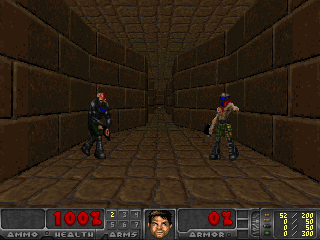

[0, 0, 0, 1]


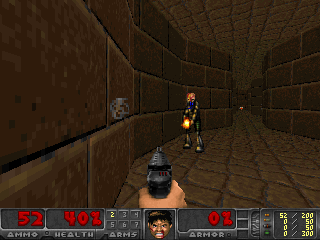

[0, 0, 0, 1]


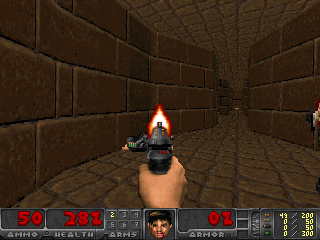

[0, 0, 0, 1]


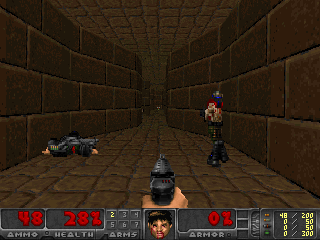

[0, 0, 0, 1]


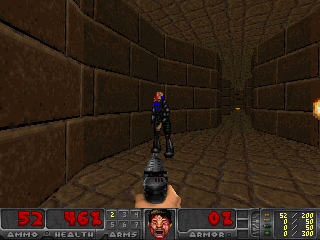

[0, 0, 0, 1]


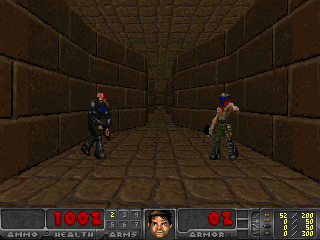

[0, 0, 0, 1]


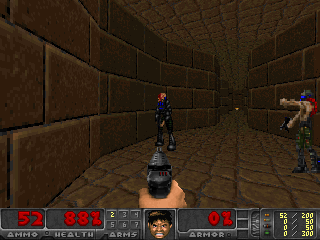

[0, 0, 0, 1]


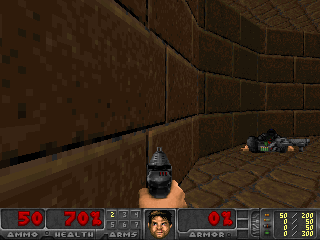

[0, 0, 0, 0]


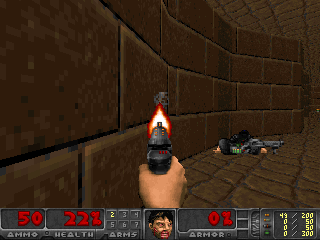

KeyboardInterrupt: 

In [ ]:
import gymnasium
from vizdoom import gymnasium_wrapper
from PIL import Image
from IPython.display import display
import base64
from langchain_openai import ChatOpenAI
import io

llm = ChatOpenAI(model="gpt-4o-mini")

actions = [
    [1, 0, 0, 0],  # Move Forward
    [0, 1, 0, 0],  # Turn Left
    [0, 0, 1, 0],  # Turn Right
    [0, 0, 0, 1],  # Shoot
    [0, 0, 0, 0],  # Do nothing
]


def pil_to_base64(img):
    img = img.resize((256, 192))
    # png bytes
    png_bytes = io.BytesIO()
    img.save(png_bytes, format="PNG")
    result = base64.b64encode(png_bytes.getvalue()).decode("utf-8")
    return result


def make_message(img):
    return {
        "role": "user",
        "content": [
            {
                "type": "text",
                "text": "You are playing a game of Doom. You are given an image of the current state of the game. Choose an action out of one of the following: move_forward, turn_left, turn_right, shoot, do_nothing. Do not include any other text in your response, just one of the above actions.",
            },
            {
                "type": "image_url",
                "image_url": {
                    "url": f"data:image/png;base64,{pil_to_base64(img)}",
                },
            },
        ],
    }

def get_response(img):
    message = make_message(img)
    response = llm.invoke([message])
    return response.content

def get_action(img):
    response = get_response(img)
    if response == "move_forward":
        return actions[0]
    elif response == "turn_left":
        return actions[1]
    elif response == "turn_right":
        return actions[2]
    elif response == "shoot":
        return actions[3]
    elif response == "do_nothing":
        return actions[4]
    else:
        print(f"Invalid response: {response}")
        return actions[4]

AGENT_FRAME_SKIP = 10
env = gymnasium.make("VizdoomCorridor-v0", frame_skip=AGENT_FRAME_SKIP)
last_frame = None

DISPLAY_FRAME_SKIP = 6


def policy(obs):
    global last_frame
    screen = obs["screen"]
    img = Image.fromarray(screen)
    if last_frame % DISPLAY_FRAME_SKIP == 0:
        display(img)
    last_frame += 1
    return get_action(img)


def run_agent():
    global last_frame

    last_frame = 0

    observation, info = env.reset()
    for _ in range(100):
        action = policy(observation)  # this is where you would insert your policy
        observation, reward, terminated, truncated, info = env.step(action)

        if terminated or truncated:
            observation, info = env.reset()


run_agent()
env.close()